# url: https://axross-recipe.com/recipes/334


# 概要

現在のマーケティングを取り巻く環境は大量生産・大量消費の時代とは異なり、マスマーケティング型の活動では、企業は競争優位性を維持できなくなってきています。

そのため、現代のマーケティングを効果的に行うためには、ミクロ視点での目標設定が必要であり、顧客シェアや顧客ロイヤルティの拡大が重要な指標となってきます。

このレシピで紹介するRFM分析は、そういった顧客管理の実現に向けた分析手法となっています。

# 実務活用例
RFM分析は、顧客の「購買日」「購買頻度」「購買金額」を元に、顧客ロイヤルティを推定する手法です。

分析を行うことによって、ロイヤルティの高い顧客へ効果的なマーケティングを行うことができます。

# RFM分析

RFM分析は、

Recency(最新購買日)…ある顧客の最後の購買日。最近購買した顧客のほうが何年も前に購買した顧客より良い顧客と考える。

Frequency(累計購買回数)…ある顧客がどの程度頻繁に購買しているか。頻度が高いほど良い顧客と考える。

Monetary(累積購買金額)…ある顧客の合計購買金額。購買金額が高いほど良い顧客と考える。

の頭文字を取ったもので、顧客の「最新購買日」「累計購買回数」「累積購買金額」の観点から顧客を識別する分析手法となります。

「最新購買日」「累計購買回数」「累積購買金額」を元に顧客ロイアルティを推定し、また3つのうちどれが一番影響を与えるかを測定して効果的なマーケティング戦略を立案するために用いられます。

次に、RFM分析のフローを説明していきます。

1. データ読み込み

2. R(最新購買日)、F(累積購買回数)、M(累積購買金額)の計算
3. R(最新購買日)、F(累積購買回数)、M(累積購買金額)をそれぞれ四分位ごとに分割
してスコア付けを行う

4. R(最新購買日)、F(累積購買回数)、M(累積購買金額)のスコアの合計を計算
スコアを元に結果の分析

といった流れになっています。

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats as st
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
df1 = pd.read_csv('/content/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

# parse_datesは、pd.read_csv関数において、CSVファイルからデータを読み込む際に、指定したカラムを日付として解釈するための引数です。
# 具体的には、parse_datesに指定されたカラムのデータが日付や時刻の形式になっている場合、Pandasはそのデータを日付型として解釈します。
# これにより、後でデータを操作する際に日付としての機能を利用できます。

# pd.read_csvを使用してデータを読み込む際、以下のようにparse_datesを指定すると、trans_date列のデータが日付として解釈されます。
# このようにすることで、trans_date列の各値がPandasの日付型 (Timestamp) に変換され、日付としての操作や解析が簡単に行えるようになります。

display(df1.sort_values('customer_id'))

#購買日のうち、一番古い日と一番新しい日を出力
display(df1['trans_date'].min(), df1['trans_date'].max())

# ＜実行結果＞: 2011-05-16 00:00:00 2015-03-16 00:00:00
# 最新購買日を求めるために、基準の日付を設定して最終購買日との差を求めます。

,customer_id,trans_date,tran_amount
89149,CS1112,2011-08-19,96
40368,CS1112,2012-12-15,76
42084,CS1112,2013-07-01,36
93074,CS1112,2012-06-24,52
17810,CS1112,2014-07-16,90
...,...,...,...
106711,CS9000,2013-10-01,71
102472,CS9000,2013-07-15,76
110180,CS9000,2012-05-12,53
123448,CS9000,2012-06-01,37


Timestamp('2011-05-16 00:00:00')

Timestamp('2015-03-16 00:00:00')

In [3]:
#2015/4/1を基準とし、最後の購買日から何日経ったかをhistで出力
sd = dt.datetime(2015, 4, 1)
df1['hist'] = sd - df1['trans_date']
df1['hist'].astype('timedelta64[D]')
df1['hist'] = df1['hist'] / np.timedelta64(1, 'D')

display(df1.head())
df1.info()

,customer_id,trans_date,tran_amount,hist
0,CS5295,2013-02-11,35,779.0
1,CS4768,2015-03-15,39,17.0
2,CS2122,2013-02-26,52,764.0
3,CS1217,2011-11-16,99,1232.0
4,CS1850,2013-11-20,78,497.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
 3   hist         125000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.8+ MB


In [4]:
# 分析結果に影響を与えてしまうので、ある一定の最終購買日より古い購買データは削除します。

#最終購買日が730日より前の購買データは削除

df1=df1[df1['hist'] < 730]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63633 entries, 1 to 124999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  63633 non-null  object        
 1   trans_date   63633 non-null  datetime64[ns]
 2   tran_amount  63633 non-null  int64         
 3   hist         63633 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
#agg関数を用いて顧客ごとに「recency」「frequency」「monetary_value」を計算

rfmTable = df1.groupby('customer_id').agg({'hist': lambda x:x.min(),
                                        'customer_id': lambda x: len(x),
                                        'tran_amount': lambda x: x.sum()})

rfmTable.rename(columns={'hist': 'recency',
                         'customer_id': 'frequency',
                         'tran_amount': 'monetary_value'}, inplace=True)

rfmTable.head()
# agg関数を用いることで、 「recency」 「frequency」 「monetary_value」を求めることができました。

,recency,frequency,monetary_value
customer_id,,,
CS1112,77.0,6,358
CS1113,51.0,11,775
CS1114,48.0,11,804
CS1115,27.0,10,765
CS1116,219.0,5,333


In [6]:
#quantile関数でデータを四分位ごとに分割

quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])
display(quartiles, type(quartiles))

,recency,frequency,monetary_value
0.25,38.0,7.0,379.0
0.50,69.0,9.0,591.0
0.75,127.0,11.0,796.0


pandas.core.frame.DataFrame

In [7]:
quartiles=quartiles.to_dict()
display(quartiles)

{'recency': {0.25: 38.0, 0.5: 69.0, 0.75: 127.0},
 'frequency': {0.25: 7.0, 0.5: 9.0, 0.75: 11.0},
 'monetary_value': {0.25: 379.0, 0.5: 591.0, 0.75: 796.0}}

In [8]:
#四分位ごとに分割されたデータにスコアを付与

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

# ここで、「recency」は値が小さい方がスコアが高くなるのでRClass関数を適用、「frequency」「monetary_value」は値が大きいほうがスコアが高くなるのでFMClass関数を適用します。

In [9]:
rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) + rfmSeg.F_Quartile.map(str) + rfmSeg.M_Quartile.map(str)
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']

display(rfmSeg.head(), rfmSeg.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6884 entries, CS1112 to CS9000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         6884 non-null   float64
 1   frequency       6884 non-null   int64  
 2   monetary_value  6884 non-null   int64  
 3   R_Quartile      6884 non-null   int64  
 4   F_Quartile      6884 non-null   int64  
 5   M_Quartile      6884 non-null   int64  
 6   RFMClass        6884 non-null   object 
 7   Total Score     6884 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 484.0+ KB


,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score
customer_id,,,,,,,,
CS1112,77.0,6,358,3,4,4,344,11
CS1113,51.0,11,775,2,2,2,222,6
CS1114,48.0,11,804,2,2,1,221,5
CS1115,27.0,10,765,1,2,2,122,5
CS1116,219.0,5,333,4,4,4,444,12


None

<Axes: xlabel='Total Score'>

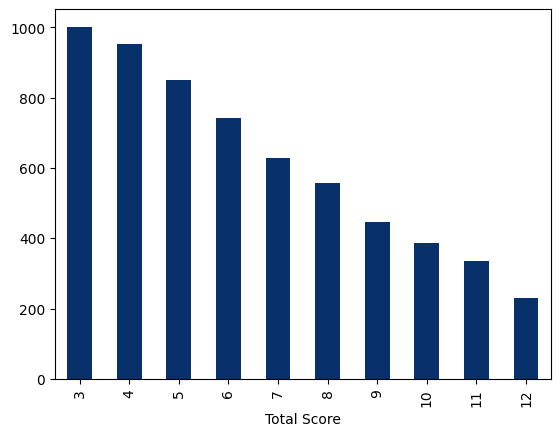

In [10]:
# ここまで、R・F・Mのスコアとトータルスコアを求めることができました。
# 次に、 「recency」「frequency」「monetary_value」と「Total Score」の関係を分析し、トータルスコアに与える影響度を分析していきます。
# R,F,MとTotal Scoreの関係を分析

rfmSeg.groupby('Total Score').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')

<Axes: xlabel='Total Score'>

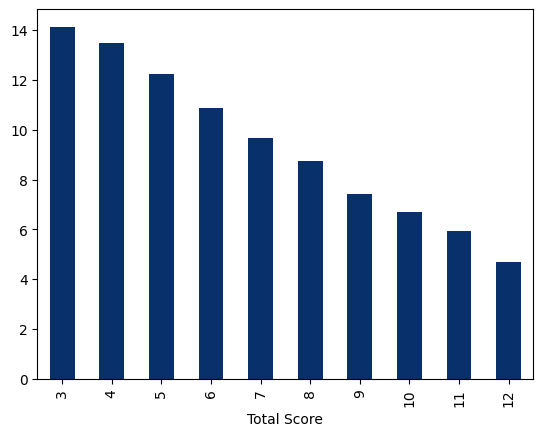

In [11]:
rfmSeg.groupby('Total Score').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')

<Axes: xlabel='Total Score'>

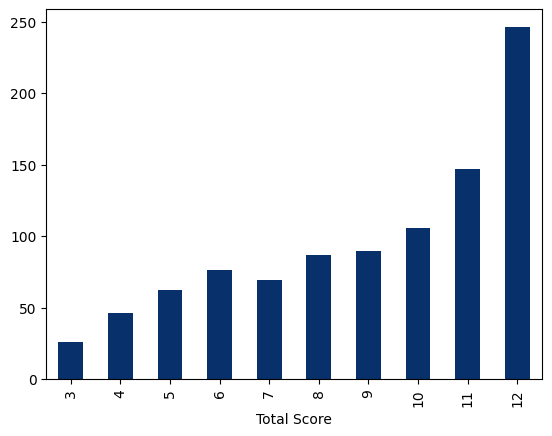

In [12]:
rfmSeg.groupby('Total Score').agg('recency').mean().plot(kind='bar', colormap='Blues_r')

In [13]:
# 分析の結果、トータルスコアが最も高い12で頻度が最も多い「recency」が、今回のデータでは重要な指標となることが推測されます。
# 続いて、「R_Quartile」「F_Quartile」「M_Quartile」のスコアをもとに、顧客のクラスタリングを行う方法を紹介していきます。

# 標準化
from sklearn.preprocessing import StandardScaler

tmp = rfmSeg[['R_Quartile', 'F_Quartile', 'M_Quartile']]
ss = StandardScaler()
rfmSeg_scaled = ss.fit_transform(tmp)

display(rfmSeg_scaled)

array([[ 0.45512788,  1.17065212,  1.34127819],
       [-0.43470465, -0.53599108, -0.44882632],
       [-0.43470465, -0.53599108, -1.34387858],
       ...,
       [ 0.45512788,  1.17065212,  1.34127819],
       [ 1.34496042,  1.17065212,  1.34127819],
       [-1.32453718,  1.17065212,  1.34127819]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'Inertia Score')

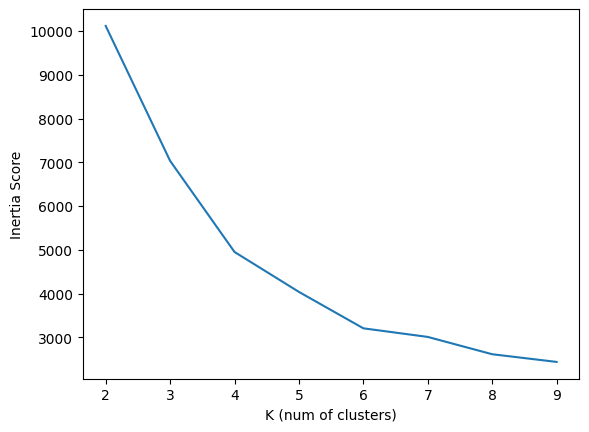

In [14]:
# エルボー法によって最適なクラスタ数を決定します。
# エルボー法を実行

from sklearn.cluster import KMeans

inertias = {}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(rfmSeg_scaled)
    inertias[k] = km.inertia_

pd.Series(inertias).plot()
plt.xlabel("K (num of clusters)")
plt.ylabel("Inertia Score")

In [15]:
# エルボー法の結果、クラスタ数は4に設定します。
#クラスタ数4でクラスタリング

k = 4
km = KMeans(n_clusters=k, random_state = 1)
rfmSeg["KMeans"] = km.fit_predict(rfmSeg_scaled)
rfmSeg.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score,KMeans
customer_id,,,,,,,,,
CS1112,77.0,6,358,3,4,4,344,11,0
CS1113,51.0,11,775,2,2,2,222,6,1
CS1114,48.0,11,804,2,2,1,221,5,1
CS1115,27.0,10,765,1,2,2,122,5,1
CS1116,219.0,5,333,4,4,4,444,12,0


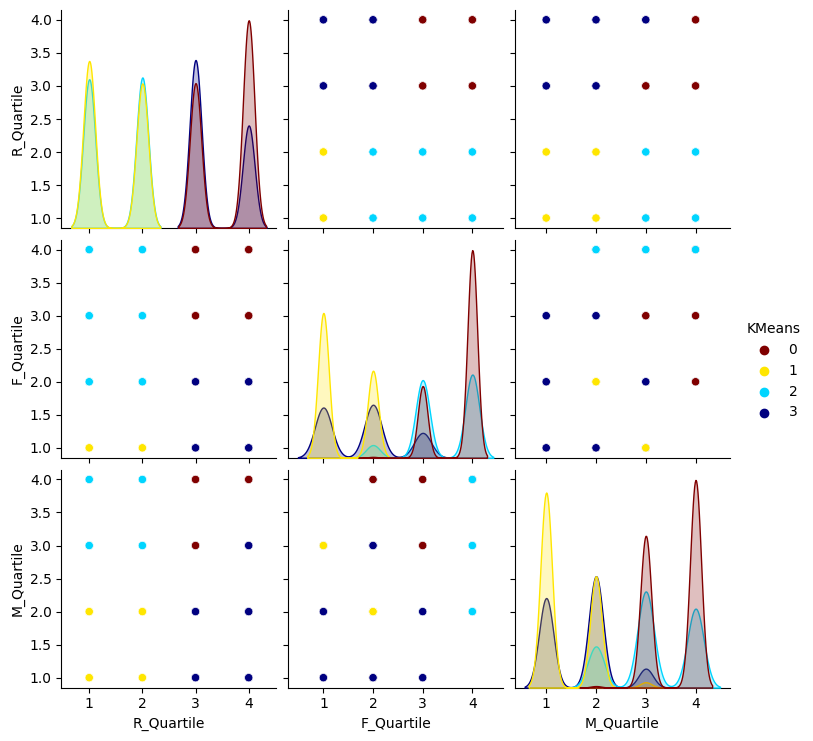

In [16]:
sns.pairplot(rfmSeg[['R_Quartile', 'F_Quartile', 'M_Quartile', 'KMeans']], hue="KMeans", palette='jet_r')
plt.show()

In [17]:
# クラスタリングの結果を可視化してみると、クラスター1が各スコアの値が大きく、顧客ロイアルティが高い顧客群であることが推測されます。
# 各クラスターの要素数の確認

rfmSeg['KMeans'].value_counts()

0    1918
1    1750
2    1696
3    1520
Name: KMeans, dtype: int64